# Data Visualisatiuon with Interpretation

What to do? <br>
- Principal Component Analysis (PCA)
- K Nearest Neibour (KNN)
- Silhouette_score and Graph
- Store the Clusterlabels and PC1 and PC2 

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib import cm

In [2]:
df = pd.read_csv('../../Data/Transformed/Julius/inventory_management_transformed.csv', index_col=0)
df.head()

,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Promotion,Competitor Pricing,Demand,PKeyID,Weekday,Price_Diff
Category,,,,,,,,,,,,,
1,1,195,102,252,72.72,5,1,0,85.73,115,0,2,-13.01
0,1,117,117,249,80.16,15,1,1,92.02,229,1,2,-11.86
0,1,247,114,612,62.94,10,1,1,60.08,157,2,2,2.86
1,1,139,45,102,87.63,10,1,0,85.19,52,3,2,2.44
3,1,152,65,271,54.41,0,1,0,51.63,59,4,2,2.78


In [4]:
# Perform PCA with a fixed number of PC of 2 in order to be able to visualize our results in two dimensions
pca = PCA(2)
pca_2d = pca.fit_transform(df)
pca_2d = pd.DataFrame(pca_2d, columns=['PC'+str(i) for i in range(1,pca_2d.shape[1]+1)])
pca_2d.head(5)

,PC1,PC2
0,-108.165308,133.277392
1,-184.407389,138.342824
2,-99.200439,497.996933
3,-148.272220,-34.170690
4,-154.800407,135.036584


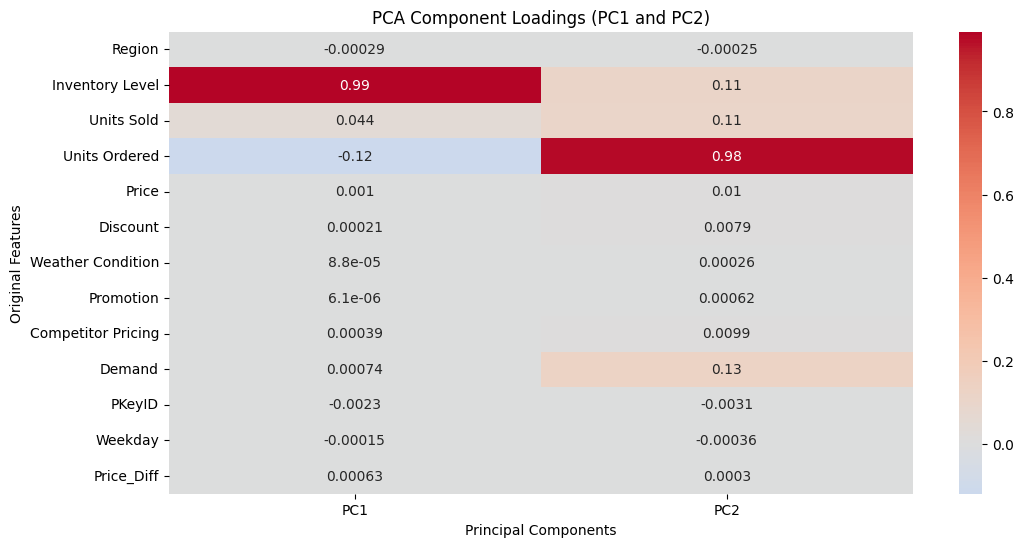

In [5]:
# We want to regain some of the lost explainability by looking out of which attributes the PCAs are composed
loadings = pd.DataFrame(pca.components_.T, 
                        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                        index=df.columns)
plt.figure(figsize=(12, 6))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
plt.title('PCA Component Loadings (PC1 and PC2)')
plt.xlabel('Principal Components')
plt.ylabel('Original Features')
plt.show()

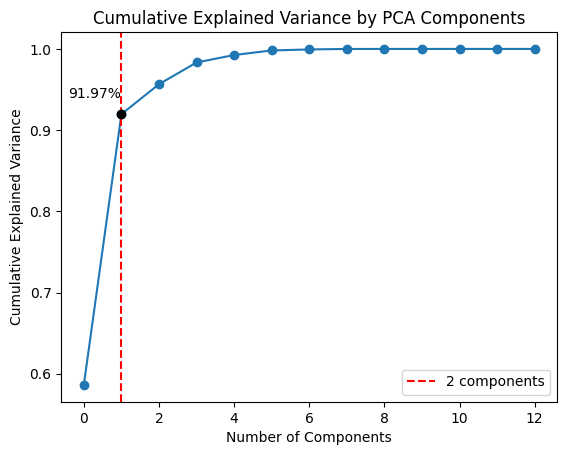

In [6]:
# We conduct a full PCA to get the information how much of the initial dimensions we can explain by using 2 dimensions
pca_full = PCA().fit(df)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Plotting
plt.plot(cumulative_variance, marker='o', linestyle='-')
# We add a vertically dashed line at k=2
plt.axvline(x=1, color='red', linestyle='--', label='2 components')
# We mark the cumulative variance at the 2nd component
y_at_x1 = cumulative_variance[1]
plt.scatter(1, y_at_x1, color='black', zorder=5)
plt.text(1, y_at_x1 + 0.02, f'{y_at_x1:.2%}', ha='right', color='black')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.legend()
plt.show()

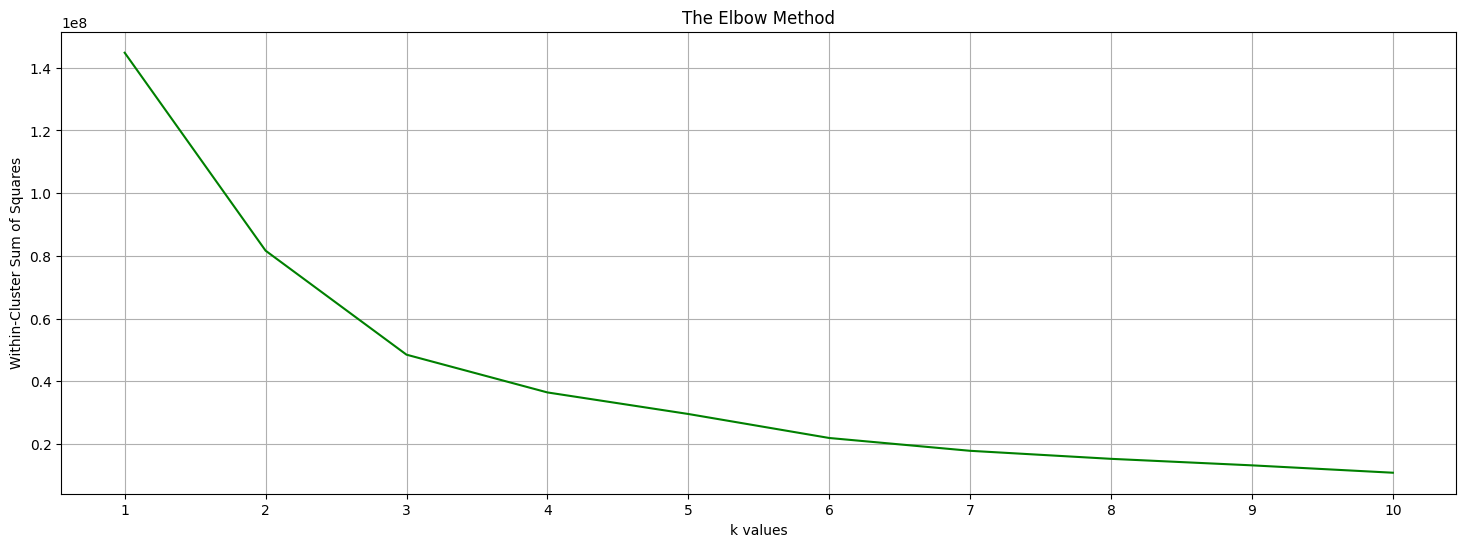

In [10]:
# We get a first hint about the optimal number of clusters with the elbow criterion
inertia_score = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pca_2d)
    inertia_score.append(kmeans.inertia_)

# We visualize the inertia scores to identify the elbow point
plt.figure(figsize=(18,6))
sns.lineplot(x=range(1,11),y=inertia_score,color='green')
plt.xticks(range(1,11))
plt.xlabel('k values')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('The Elbow Method')
plt.grid()
plt.show()

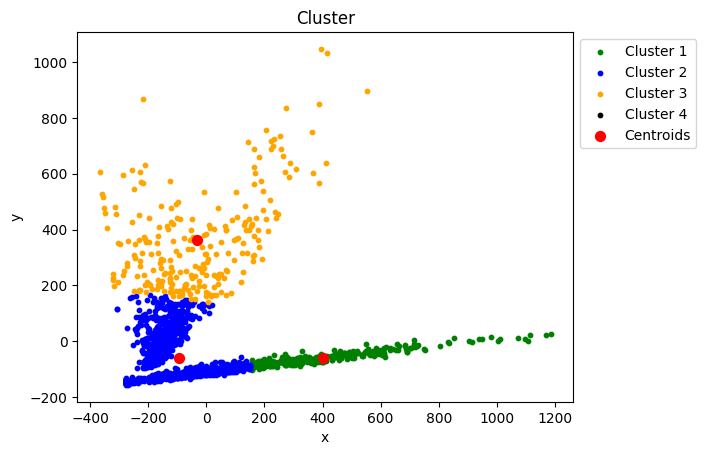

In [15]:
# We visualize the clusters based on the elbow criteria, we decide on taking 3 because it sits int he ellbow
# decrease in heterogeneity at this point
kmeans = KMeans(n_clusters=3, init="k-means++", n_init=10, random_state=42)
y_kmeans = kmeans.fit_predict(pca_2d)
Y_np_2d = pca_2d.to_numpy()
plt.scatter(Y_np_2d[y_kmeans == 0, 0], Y_np_2d[y_kmeans == 0, 1], s = 10, c = 'green', 
            label = 'Cluster 1')
plt.scatter(Y_np_2d[y_kmeans == 1, 0], Y_np_2d[y_kmeans == 1, 1], s = 10, c = 'blue', 
            label = 'Cluster 2')
plt.scatter(Y_np_2d[y_kmeans == 2, 0], Y_np_2d[y_kmeans == 2, 1], s = 10, c = 'orange', 
            label = 'Cluster 3')
plt.scatter(Y_np_2d[y_kmeans == 3, 0], Y_np_2d[y_kmeans == 3, 1], s = 10, c = 'black', 
            label = 'Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 50, 
            c = 'red', label = 'Centroids')
plt.title('Cluster')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

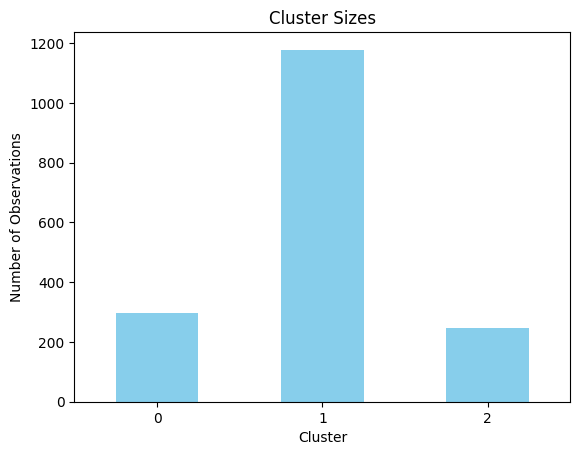

In [16]:
# For further insights we analyze how the observations are distributed in the different clusters
pd.Series(y_kmeans).value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.show()

In [17]:
# We calculate the silhouette score based on the suggestion of the elbow criteria
silhouette_score(pca_2d, y_kmeans)

0.5433556283901221

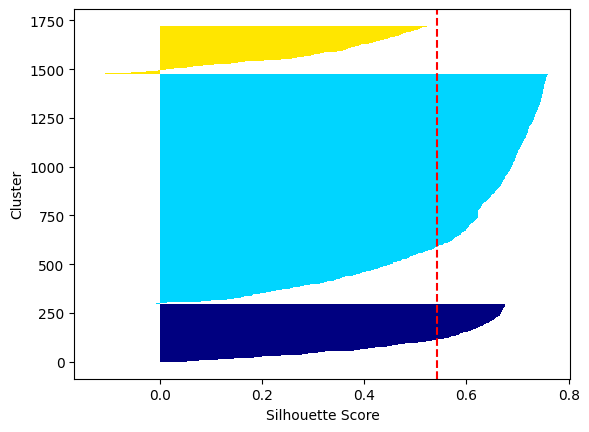

In [20]:
# We visualize the average silhouette scores for k=4 based on the elbow criteria
cluster_labels = np.unique(y_kmeans)
n_clusters=cluster_labels.shape [0]

silhouette_vals = silhouette_samples(pca_2d, y_kmeans, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_kmeans == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet( i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
            c_silhouette_vals,
            height = 1.0,
            edgecolor = 'none',
            color = color)
    yticks.append((y_ax_lower + y_ax_upper) / 2 )
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color = 'red', linestyle = "--")
plt.ylabel('Cluster')
plt.xlabel('Silhouette Score')
plt.show()

In [21]:
# We can calculate the silhouette scores of different numbers of clusters to evaluate the optimal number of clusters with a simple for loop
best_k = None
best_score = -1

for k in range(2, 10): 
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
    y_kmeans = kmeans.fit_predict(pca_2d)
    score = silhouette_score(pca_2d, y_kmeans)
    print("The silhouette score for k = ",k," is ",score)
    
    if score > best_score:
        best_score = score
        best_k = k

print("Best k:",best_k,"with a silhouette score of ",best_score)

The silhouette score for k =  2  is  0.53920139873622
The silhouette score for k =  3  is  0.5433556283901221
The silhouette score for k =  4  is  0.4533890890145445
The silhouette score for k =  5  is  0.4503942616312993
The silhouette score for k =  6  is  0.4394949720256169
The silhouette score for k =  7  is  0.43468315302888194
The silhouette score for k =  8  is  0.4414239031320489
The silhouette score for k =  9  is  0.43977826606328085
Best k: 3 with a silhouette score of  0.5433556283901221


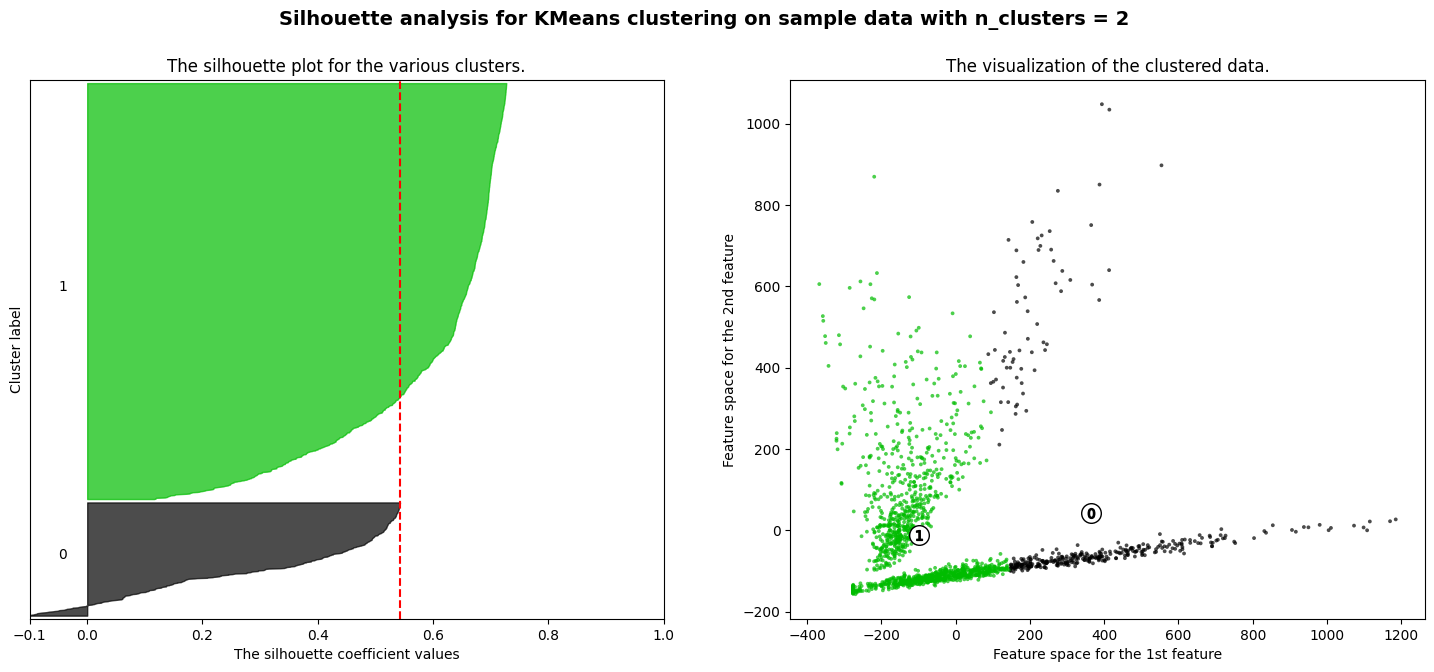

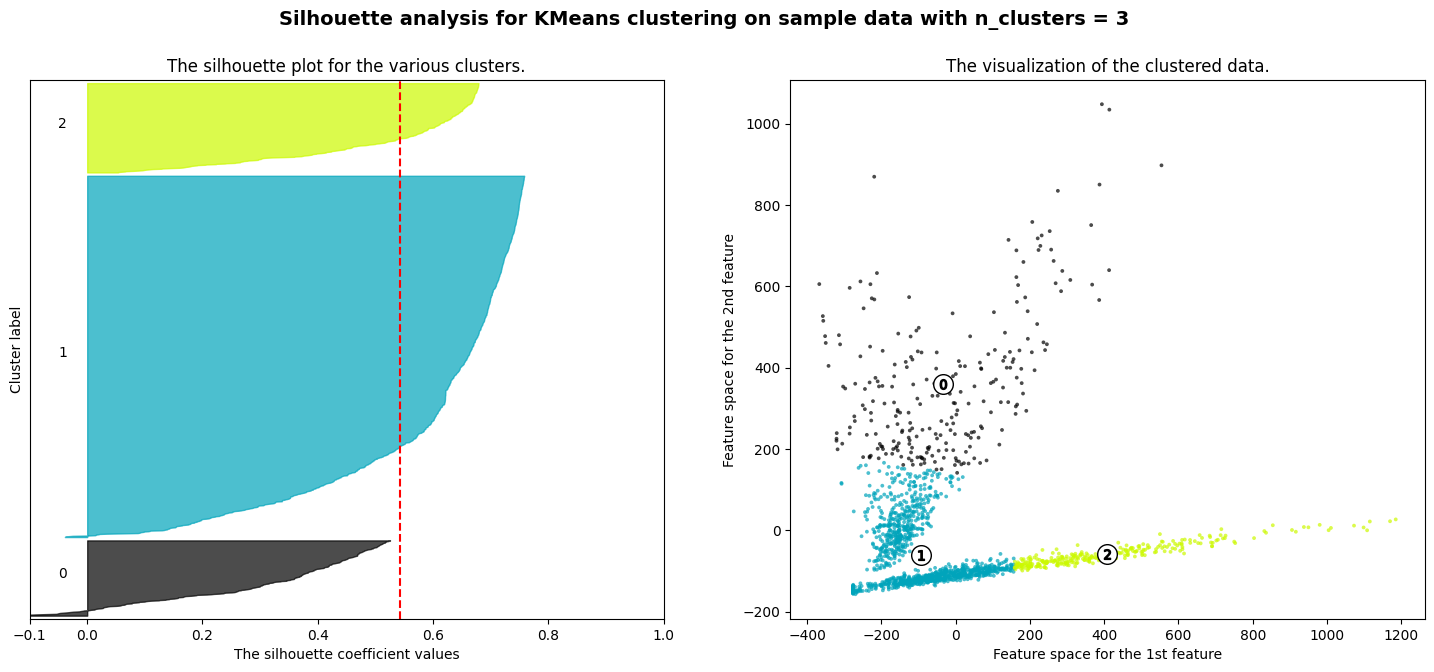

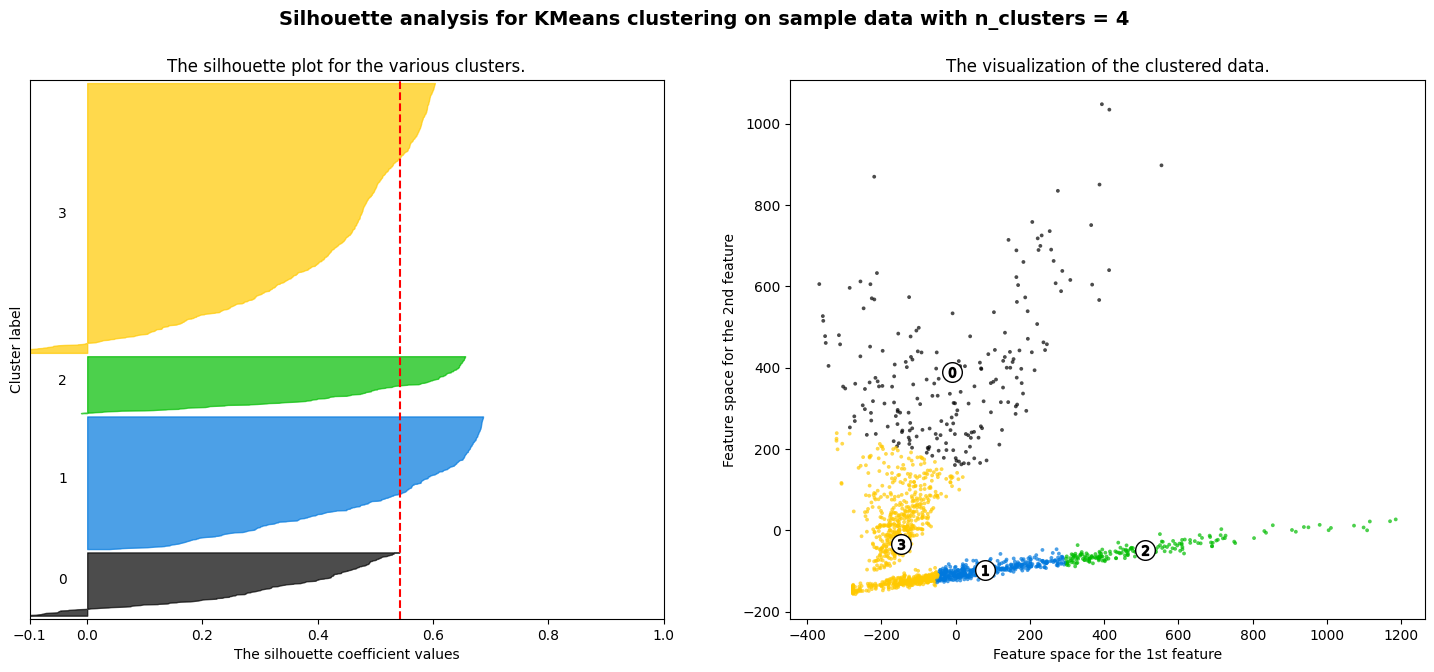

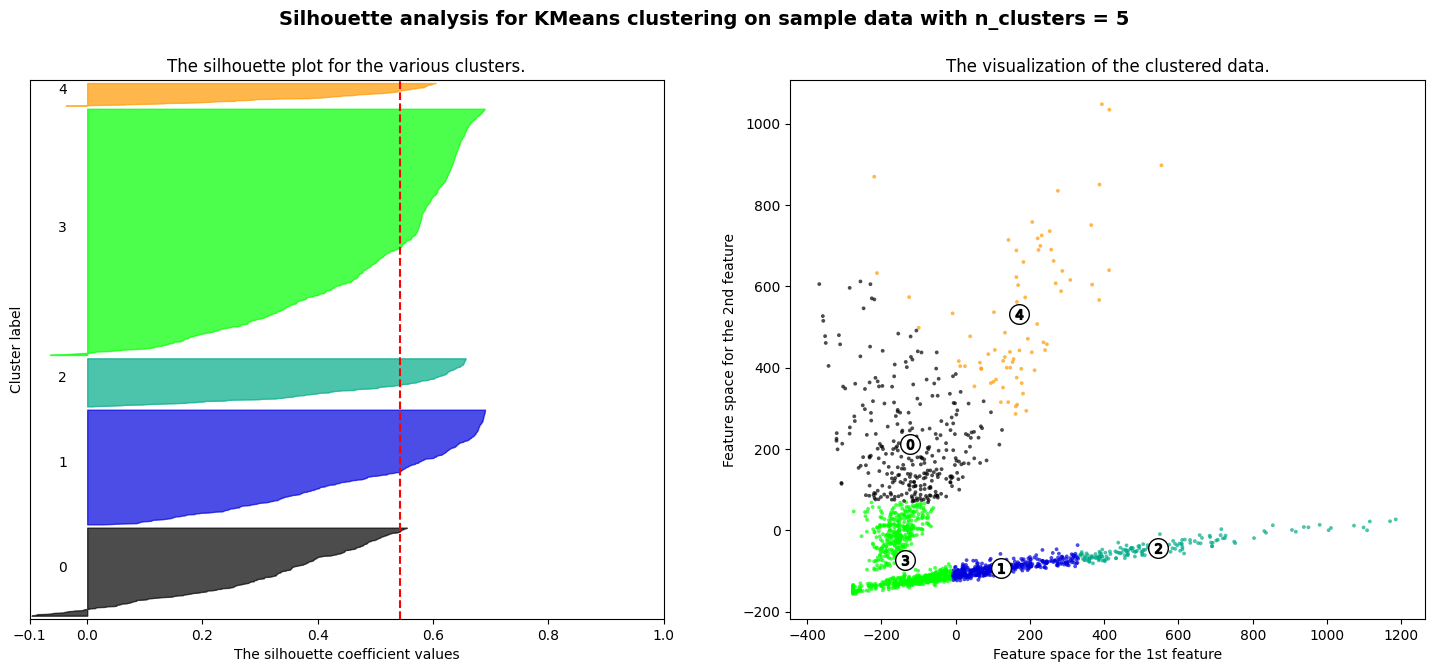

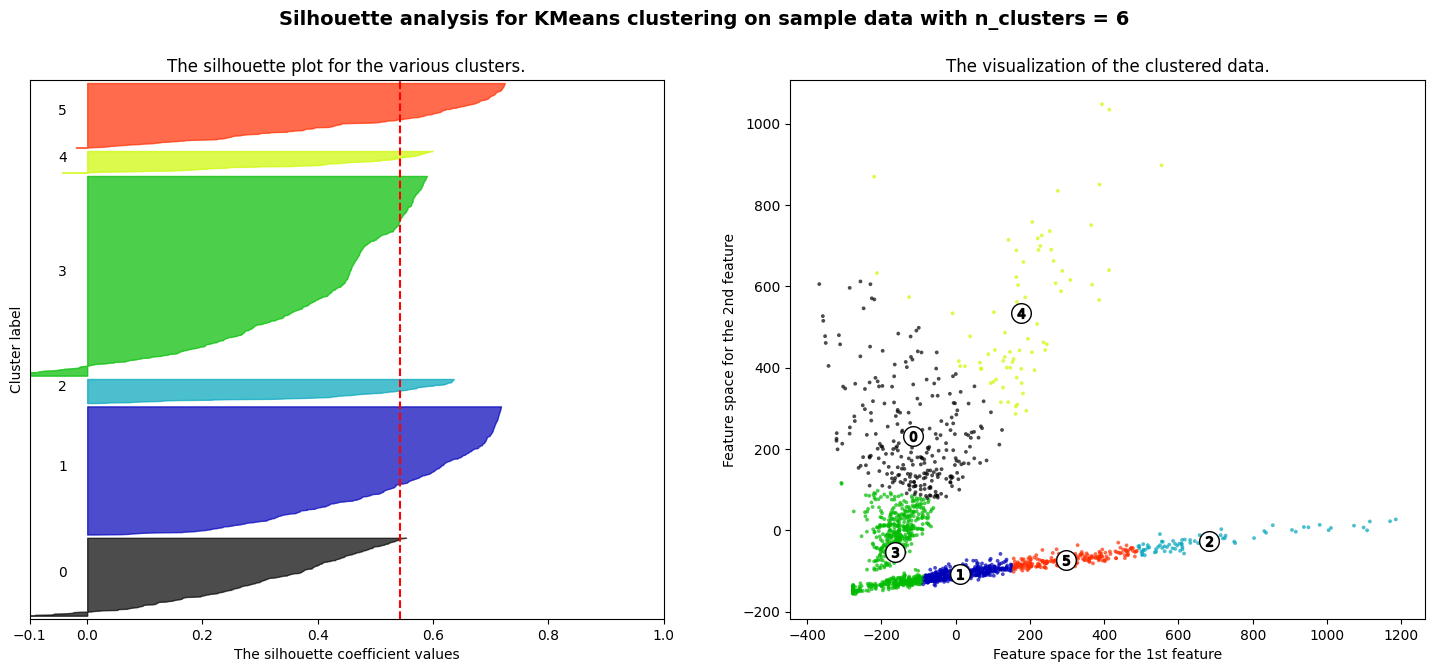

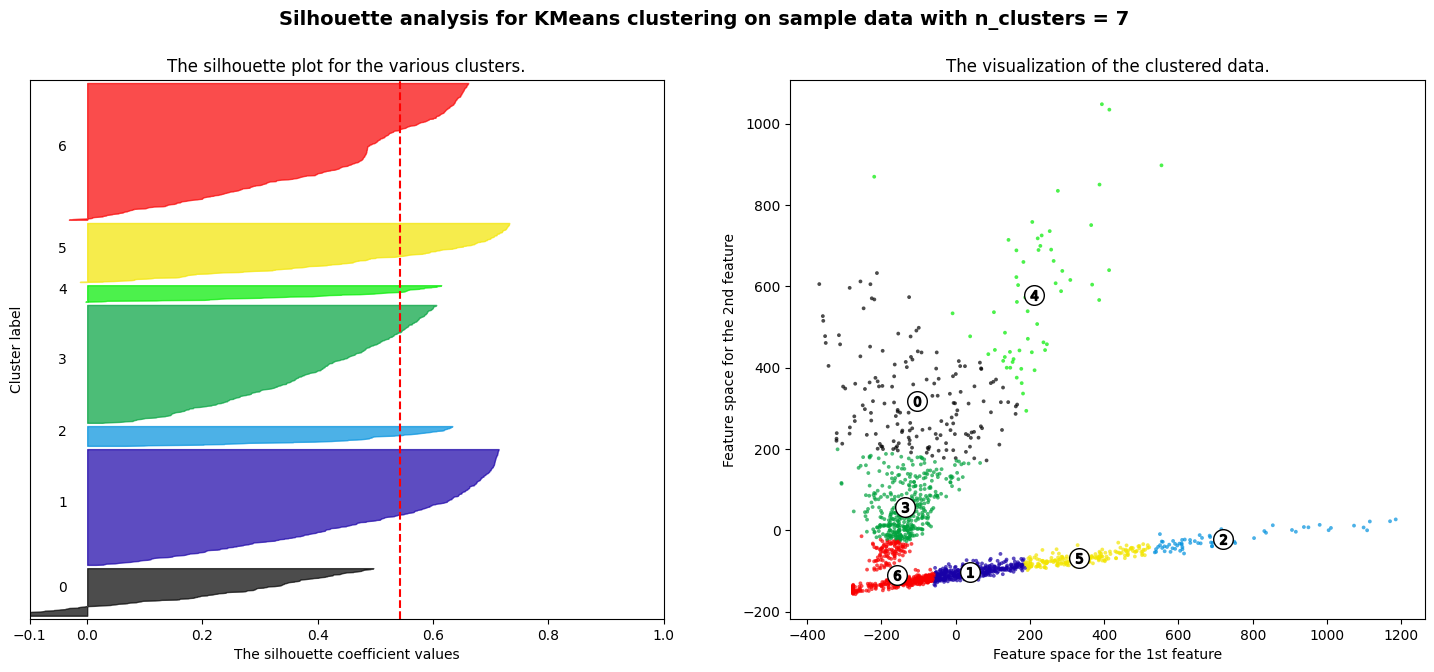

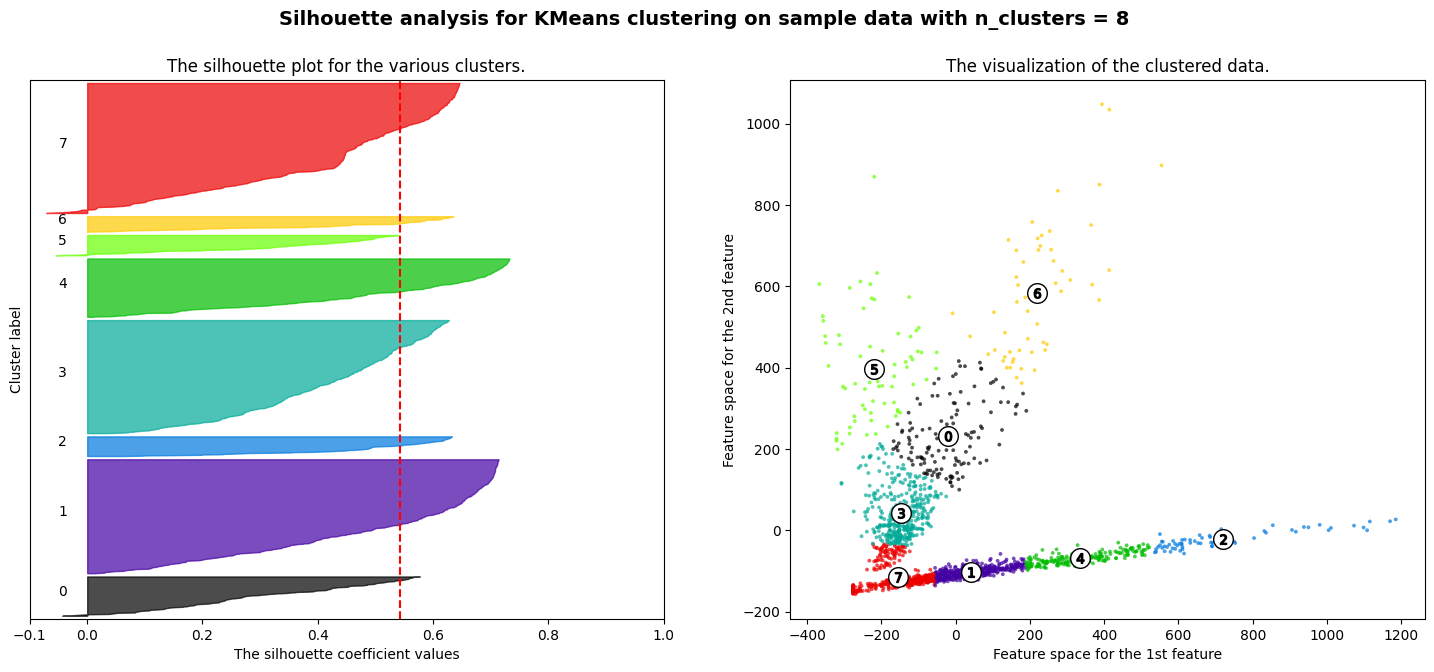

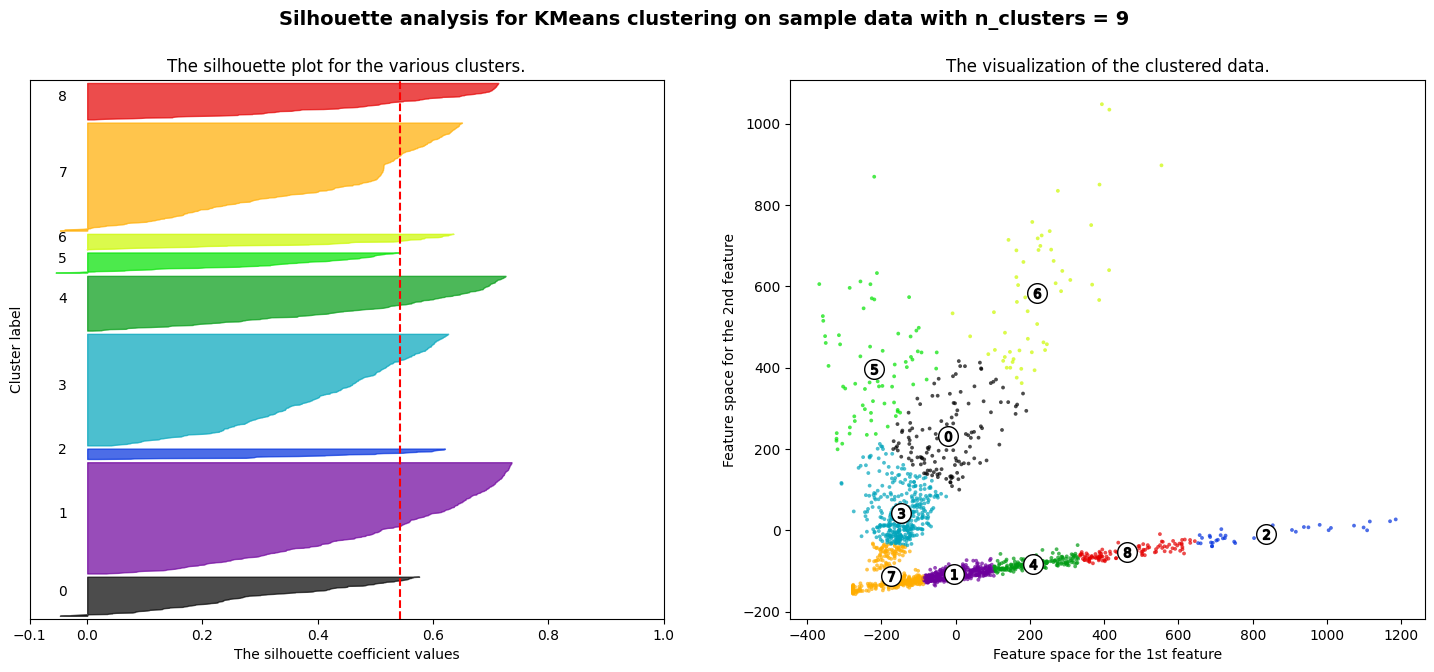

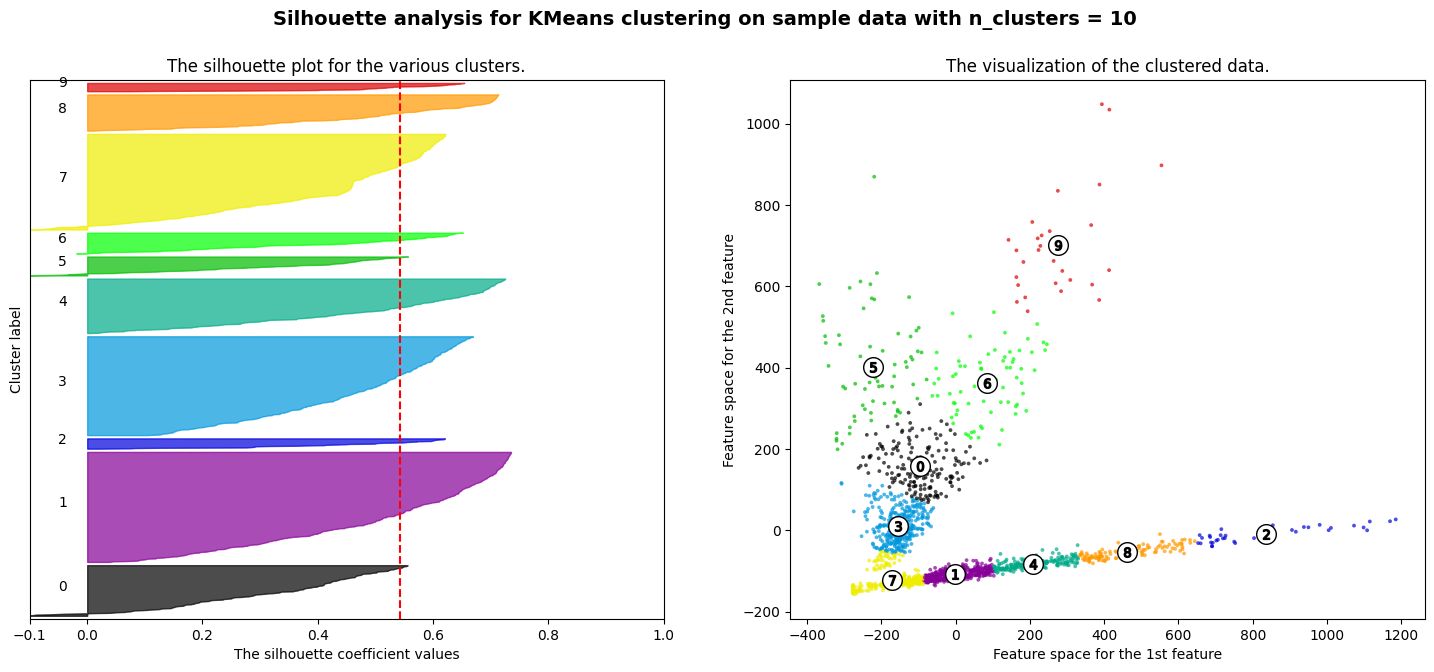

In [22]:
# We visualize the different silhouette scores of different numbers of clusters to confirm that k=6 is the optimal choice
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(Y_np_2d) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(Y_np_2d)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(Y_np_2d, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(Y_np_2d[:, 0], Y_np_2d[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

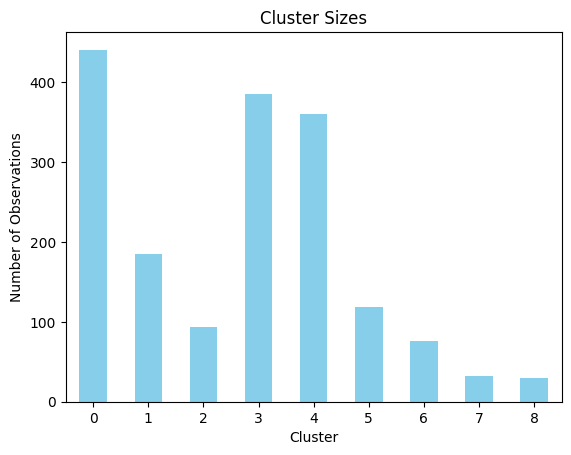

In [23]:
# We analyze how the observations are distributed in the different clusters
pd.Series(y_kmeans).value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.show()

In [24]:
# This again shows the silhoutte score for the optimal number of clusters k = 6
silhouette_score(pca_2d, y_kmeans)

0.43977826606328085

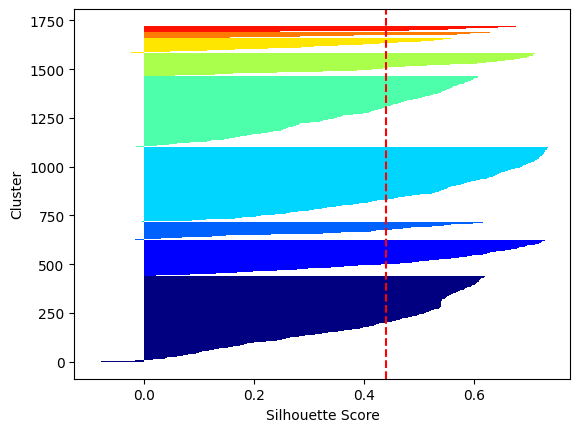

In [25]:
# We visualize the average silhouette scores of the optimal k 
cluster_labels = np.unique(y_kmeans)
n_clusters=cluster_labels.shape [0]

silhouette_vals = silhouette_samples(pca_2d, y_kmeans, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_kmeans == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet( i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
            c_silhouette_vals,
            height = 1.0,
            edgecolor = 'none',
            color = color)
    yticks.append((y_ax_lower + y_ax_upper) / 2 )
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color = 'red', linestyle = "--")
plt.ylabel('Cluster')
plt.xlabel('Silhouette Score')
plt.show()